<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/game_Master_Mind_CP_Pyomo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Developed by Alireza Soroudi
alireza.soroudi@gmail.com

Linkedin News letter : https://www.linkedin.com/newsletters/optimization-in-open-source-6874020019009859585/

Git hub: https://github.com/OptimizationExpert/Pyomo



Problem description
https://projecteuler.net/problem=185

The game Number Mind is a variant of the well known game Master Mind.

Instead of coloured pegs, you have to guess a secret sequence of digits. After each guess you're only told in how many places you've guessed the correct digit. So, if the sequence was 1234 and you guessed 2036, you'd be told that you have one correct digit; however, you would NOT be told that you also have another digit in the wrong place.

For instance, given the following guesses for a 5-digit secret sequence,



```
90342 ;2 correct
70794 ;0 correct
39458 ;2 correct
34109 ;1 correct
51545 ;2 correct
12531 ;1 correct
```



The correct sequence 39542 is unique.

In [62]:
!pip install ortools
from ortools.sat.python import cp_model # CP-SAT solver
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt # Data visualization


,seq,correct
0,5616185650518293,2
1,3847439647293047,1
2,5855462940810587,3
3,9742855507068353,3
4,4296849643607543,3
5,3174248439465858,1
6,4513559094146117,2
7,7890971548908067,3
8,8157356344118483,1
9,2615250744386899,2


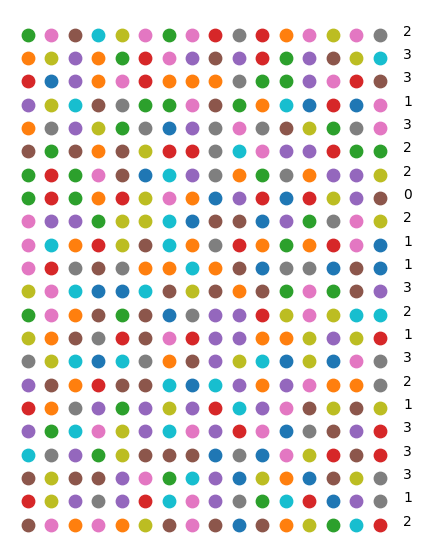

In [63]:
KOLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
            "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
            "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
            "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
            "#8c6d31", "#9c9ede", "#637939", "#e7cb94", "#b5cf6b",
            "#cedb9c", "#c7c7c7", "#bd9e39", "#e7969c", "#7b4173"]

data = {
    'seq': [90342, 70794, 39458, 34109, 51545, 12531],
    'correct': [2, 0, 2, 1, 2, 1]
}

data = {
    'seq': [
        5616185650518293, 3847439647293047, 5855462940810587, 9742855507068353,
        4296849643607543, 3174248439465858, 4513559094146117, 7890971548908067,
        8157356344118483, 2615250744386899, 8690095851526254, 6375711915077050,
        6913859173121360, 6442889055042768, 2321386104303845, 2326509471271448,
        5251583379644322, 1748270476758276, 4895722652190306, 3041631117224635,
        1841236454324589, 2659862637316867
    ],
    'correct': [
        2, 1, 3, 3, 3, 1, 2, 3, 1, 2, 3, 1, 1, 2, 0, 2, 2, 3, 1, 3, 3, 2
    ]
}


df = pd.DataFrame(data)
plt.figure(figsize=(5,7))
for r in range(len(df)):
  vals = str(df.loc[r,'seq'])
  for i in range(len(vals)):
    kolor_indx = int(vals[i])
    plt.scatter(i,r, s= 80, c=KOLORS[kolor_indx])
  plt.text(i+1,r-0.05, s= df.loc[r,'correct'])

plt.axis('off')
df

## CP Model in ORTools

In [64]:
model = cp_model.CpModel()
solver = cp_model.CpSolver()
N= 5
N = len(str(df.loc[0,'seq']))
rows = range(len(df))

V = {i:model.NewIntVar(0,9,f"scen_day_{i}")  for i in range(N)}
U = {(i,r):model.NewBoolVar(f"correct_{i}")  for i in range(N) for r in rows}

for r in rows:
  vals = str(df.loc[r,'seq'])
  for i in range(N):
    model.Add(V[i]==int(vals[i])).OnlyEnforceIf(U[i,r])
    model.Add(V[i]!= int(vals[i])).OnlyEnforceIf(U[i,r].Not())
  expressions = [U[i,r] for i in range(N) ]
  model.Add(sum(expressions) == int(df.loc[r,'correct']) )

status = solver.Solve(model)

if status == cp_model.OPTIMAL:
  print("OPTIMAL")
elif status == cp_model.FEASIBLE:
  print("FEASIBLE")
elif status == cp_model.INFEASIBLE:
  print("INFEASIBLE")
  print("FEASIBLE")
elif status == cp_model.UNKNOWN:
  print("UNKNOWN")
print(solver.ObjectiveValue())

a= [ solver.value(V[i]) for i in range(N)]
print(a)

OPTIMAL
0.0
[4, 6, 4, 0, 2, 6, 1, 5, 7, 1, 8, 4, 9, 5, 3, 3]


In [65]:
!pip install pyomo
from pyomo.environ import *
!apt-get install -y -qq coinor-cbc
opt = SolverFactory('cbc', executable='/usr/bin/cbc')

## MILP Model in Pyomo

In [66]:
model = AbstractModel()

N = len(str(df.loc[0,'seq']))
rows = range(len(df))

model.i = Set(initialize=[i for i in range(N)])
model.r = Set(initialize=rows)

model.V = Var(model.i, bounds=(0,9), within=NonNegativeIntegers)
model.U = Var(model.i,model.r, within=Binary)
model.I = Var(model.i,model.r, within=Binary)
model.P = Var(model.i,model.r, within=Binary)

def rule_C1A(model,r,i):
  vals = str(df.loc[r,'seq'])
  return model.V[i]-int(vals[i]) <= 10*(1-model.U[i,r])
model.C1A=Constraint(model.r, model.i, rule=rule_C1A)

def rule_C1B(model,r,i):
  vals = str(df.loc[r,'seq'])
  return -(model.V[i]-int(vals[i])) <= 10*(1-model.U[i,r])
model.C1B=Constraint(model.r, model.i, rule=rule_C1B)


def rule_C3A(model,r,i):
  vals = str(df.loc[r,'seq'])
  return (model.V[i]-int(vals[i])) >= 1 - 10*(1-model.I[i,r])  - 10*model.U[i,r]
model.C3A=Constraint(model.r, model.i, rule=rule_C3A)


def rule_C3B(model,r,i):
  vals = str(df.loc[r,'seq'])
  return (model.V[i]-int(vals[i])) <= -1 + 10*(1-model.P[i,r])  + 10*model.U[i,r]
model.C3B=Constraint(model.r, model.i, rule=rule_C3B)

def rule_C3C(model,r,i):
  vals = str(df.loc[r,'seq'])
  return model.P[i,r] + model.I[i,r]  == 1- model.U[i,r]
model.C3C=Constraint(model.r, model.i, rule=rule_C3C)

def rule_C2(model,r):
  return sum(model.U[i,r] for i in model.i ) == int(df.loc[r,'correct'])
model.C2=Constraint(model.r, rule=rule_C2)

def rule_OF(model):
    return  sum(model.V[i] for i in model.i)
model.obj1 = Objective(rule=rule_OF, sense=minimize)
instance = model.create_instance()

results = opt.solve(instance) # solves and updates instance
from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal and nothing more")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print ('ERROR ' + str(results.solver))

print('OF= ', value(instance.obj1) )

a= [ int(value(instance.V[i])) for i in instance.i]
print(a)

this is feasible and optimal and nothing more
OF=  68.0
[4, 6, 4, 0, 2, 6, 1, 5, 7, 1, 8, 4, 9, 5, 3, 3]


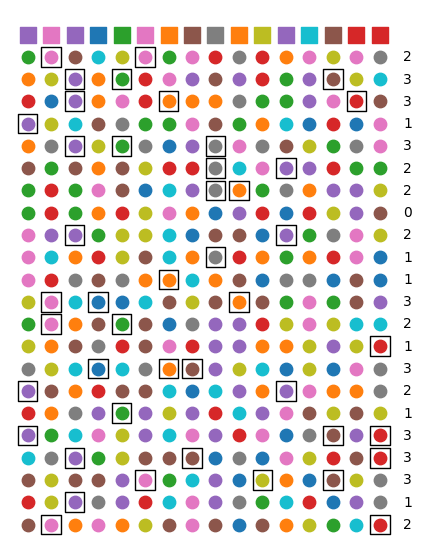

In [67]:
plt.figure(figsize=(5,7))
for r in range(len(df)):
  vals = str(df.loc[r,'seq'])
  for i in range(len(vals)):
    kolor_indx = int(vals[i])
    plt.scatter(i,r, s= 80, c=KOLORS[kolor_indx])
    if value(instance.U[i,r])>0:
       plt.scatter(i,r, s= 200, edgecolor='k', facecolors='none', marker ='s')
  plt.text(i+1,r-0.2, s= df.loc[r,'correct'])

for i in range(len(vals)):
  kolor_indx = int(value(instance.V[i]))
  plt.scatter(i,r+1, s= 120, marker = 's', c=KOLORS[kolor_indx])


plt.axis('off')
plt.show()